# День пятый - интерпретация, внедрение и другие темы

Сегодня нас ждут:
- некоторые методы локальной интерпретации
- как создать веб-сервис на `flask`, как сохранить и загрузить модель
- презентация `jupyter notebooks` на `voila` и немного `streamlit`
- элементы мониторинга после внедрения

факультативно:
- немного о вероятностном программировании
- вариационные автокодировщики (будем генерировать картинки).

## 5.1 Методы интерпретации

Как ранее уже упоминалось, методы интерпретации модели могут быть глобальными (как важность признаков у деревьев), а могут быть локальными, то есть теми, которые объясняют почему предсказание для конкретного примера именно такое.

Сейчас мы рассмотрим библиотеку `shap` (`SHapely Additive exPlanations`, где в названии, *Shapely* - это фамилия), которая такие предсказания и позволяет делать. И делает это она благодаря некоторым результатам из теории игр.

Представим себе признаки как игроков, а результат "игры" - это предсказание модели для этих признаков (разово). Тогда `shap` позволяет судить о вкладе каждого игрока в "выигрыш" (предсказание) - для этого рассматривается каждый поднабор из всех признаков (сочетания), от нуля признаков до всех, и для каждого поднабора учится своя модель. При добавлении признака в набор, он даёт некоторый вклад (эффект) в предсказание. Все эффекты для вхождений каждого признака количественно взвешиваются, они есть итоговый эффект каждого признака.

А теперь представьте что у нас (всего) 10 признаков, это означает что нам надо перебрать `2**10` моделей (с различными наборами признаков). Мы, конечно, этим заниматься не будем, и благодаря библиотеке `shap`, умеющей во всевозможные оптимизации подобных вычислений и прочие ухищрения, всё получается быстрее.

In [1]:
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загрузим датасет ракушек
data = pd.read_csv('data/abalone.csv')

# немного препроцессинга
data['sex'] = data.sex.apply(lambda sex: {
    'F': 0, 'M': 1, 'I': 2
}[sex])

data.sample(3)

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
1771,2,0.455,0.325,0.135,0.820,0.4005,0.1715,0.2110,8
623,0,0.500,0.385,0.105,0.498,0.1795,0.1095,0.1700,17
3763,2,0.530,0.410,0.150,0.612,0.2435,0.1525,0.1895,11


In [2]:
import shap

Библиотека `shap` может объяснять модели на базе деревьев (`TreeExplainer`), линейные (`LinearExplainer`, требуются независимые - они же несвязанные - признаки), нейронные сети `keras` (`DeepExplainer`), а также произвольные модели (`KernelExplainer`) - но увы весьма медленно.

На данный момент, `TreeExplainer` не умеет в мультикласс, поэтом в этих случаях надо пользоваться универсальным `KernelExplainer`, и следует отметить, что он требует чтобы у модели был метод `predict_proba` (предсказывает вероятность - или уверенность - в классе). Таким методом обладают, например, все деревья.

Мы же пока тем временем попробуем объяснить результаты работы регрессора.

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

# отложим 100 сэмплов
indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-100]
test = indices[-100:]

regressor = GradientBoostingRegressor(
    n_estimators=15, max_depth=7, random_state=1
).fit(data.iloc[train,:-1], data.iloc[train, -1])

print("test score %.3f" % regressor.score(
    data.iloc[test,:-1], data.iloc[test, -1]
))

explainer = shap.TreeExplainer(regressor, data=data.iloc[test, :-1])
shap_values_test = explainer.shap_values(data.iloc[test, :-1]);

test score 0.361


In [4]:
print('True rings value for first test sample = %d' % data.iloc[test[0], -1])

True rings value for first test sample = 11


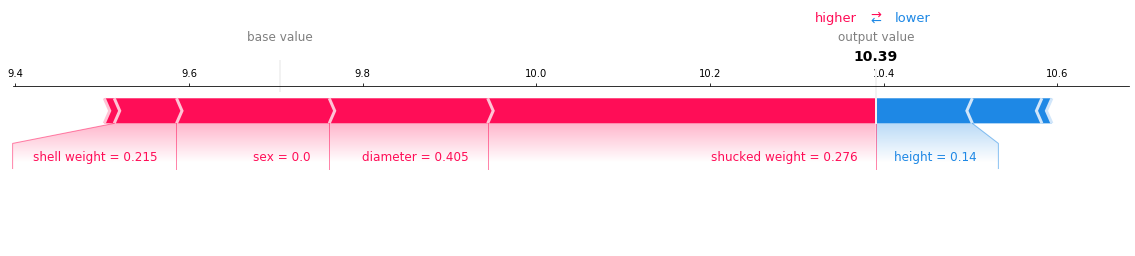

In [5]:
shap.force_plot(explainer.expected_value, shap_values_test[0], data.iloc[test[0],:-1], matplotlib=True)

На это диаграмме красным - то что добавило нам колец, а синим - то, что (для этой ракушки) убавило. Причем подписано сколько колец добавлено/убавлено. Лично я считаю, что для регрессии подобные объяснения очень наглядны. 

Для классификации есть же нечто, скажем так, поинтереснее, а именно `Alibi Trust Scores` - уровни доверия. Это мера соответствия между предсказанным классом, и тем, какие ближайшие соседи у этого класса. Условно, если предсказанный класс примера находится рядом с множеством подобных - тем больше мы можем верить предсказанию. А если не условно, то это по аналогии с `silhoutte_score` - отношение между расстоянием до ближайшего класса, отличного от предсказанного, к расстоянию до предсказанного класса. Следовательно, если эта величина больше 1, и чем она вообще больше, тем больше доверия к предсказанию.

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = GradientBoostingClassifier(
    n_estimators=15, max_depth=3, random_state=1
).fit(data.iloc[train,1:], data.iloc[train, 0])

print("test score %.3f" % classifier.score(
    data.iloc[test,1:], data.iloc[test, 0]
))

test score 0.580


In [7]:
from alibi.confidence import TrustScore
ts = TrustScore(
    # тут могут быть настройки, но мы
    # оставим всё по умолчанию
)

ts.fit(
    data.iloc[train,1:].values,
    data.iloc[train, 0].values,
    classes=3
)

In [8]:
predicted = classifier.predict([data.iloc[test[0], 1:]])[0]
print("True class %d, predicted %d" % (
    data.iloc[test[0], 0],
    predicted
))

trust_scores, closest_classes = ts.score(
    np.array([data.iloc[test[0], 1:]]),
    np.array([predicted])
)

print("Proba %.3f, TrustScore %.3f, closest class %d" % (
    classifier.predict_proba(
        data.iloc[test[0], 1:].values.reshape(1, -1)
    )[0][0],
    trust_scores[0], closest_classes[0]
))

True class 0, predicted 2
Proba 0.330, TrustScore 0.745, closest class 0


Тут видим, `trust score < 1` , и ближайший класс точнее. Впрочем, здесь и вероятность предсказания не самая высокая (да и классификатор так себе).

А сейчас мы рассмотрим технику, которая позволяет одновременно отбирать признаки и строить некоторую интерпретацию вида "мы тут можем ошибаться на столько-то" (*model perfomance prediction*). Нужно построить регрессор (в случае классификации - классификатор), который будет обучен (на отложенной валидации, поскольку стэкинг) предсказывать ошибки алгоритма.

Посмотрим на эту позаимствованную (получается уже дважды) картинку.
![MPP](media/mpp.png)

In [9]:
indices = shuffle(list(range(len(data))), random_state=1)
train = indices[:-2000]
val = indices[-2000:-1000]
test = indices[-1000:]

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.pipeline import make_pipeline

preprocessor_regression = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_regression_train = preprocessor_regression.fit_transform(data.iloc[train,1:-1])
X_regression_val = preprocessor_regression.transform(data.iloc[val,1:-1])
X_regression_test = preprocessor_regression.transform(data.iloc[test,1:-1])

preprocessor_classification = make_pipeline(PowerTransformer(), PolynomialFeatures(degree=3))
X_classification_train = preprocessor_classification.fit_transform(data.iloc[train,1:])
X_classification_val = preprocessor_classification.transform(data.iloc[val,1:])
X_classification_test = preprocessor_classification.transform(data.iloc[test,1:])

regressor = Ridge(random_state=1).fit(
    X_regression_train, data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train, data.iloc[train, 0]
)

print("simple: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test, data.iloc[test, -1]),
    classifier.score(X_classification_test, data.iloc[test, 0])
))

simple: r2 0.526, acc 0.528


In [10]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

def get_error_models(regression_features, classifier_features):
    error_regressor = GradientBoostingRegressor(
        n_estimators=30, max_depth=5, random_state=1
    ).fit(
        X_regression_val[:, regression_features],
        np.abs(
            regressor.predict(X_regression_val[:, regression_features]) - data.iloc[val,-1]
        )
    )

    error_classifier = GradientBoostingClassifier(
        n_estimators=30, max_depth=5, random_state=1
    ).fit(
        X_classification_val[:, classifier_features],
        (
            classifier.predict(X_classification_val[:, classifier_features]) != data.iloc[val,0]
        ).astype(int)
    )
    return error_regressor, error_classifier

error_regressor, error_classifier = get_error_models(
    regression_features=slice(None),
    classifier_features=slice(None)
)

Мы получили регрессор ошибки и классификатор ошибки. Их можно использовать и для отбора признаков (в обоих случаях уберем несколько неважных признаков и посмотрим), и для проверки корректности предсказания.

In [11]:
redundand = 10

regressor_features = np.argsort(error_regressor.feature_importances_)[redundand:]
classifier_features = np.argsort(error_classifier.feature_importances_)[redundand:]

regressor = Ridge(random_state=1).fit(
    X_regression_train[:, regressor_features], 
    data.iloc[train, -1]
)

classifier = LogisticRegression(random_state=1).fit(
    X_classification_train[:, classifier_features],
    data.iloc[train, :1]
)

print("selected: r2 %.3f, acc %.3f" % (
    regressor.score(X_regression_test[:, regressor_features], data.iloc[test, -1]),
    classifier.score(X_classification_test[:, classifier_features], data.iloc[test,0])
))

selected: r2 0.540, acc 0.537


В данном случае мы убрали признаки, которые давали *наименьший вклад в объяснение ошибки*. Это означает, что они имеют слабое влияния на то, как предсказывает изначальная модель. Давайте посмотрим на ошибку предсказания для конкретного примера.

In [12]:
error_regressor, error_classifier = get_error_models(
    regressor_features, classifier_features
)

print("regression: True %d, Predicted %.2f, error %.3f" % (
    data.iloc[test[0], -1],
    regressor.predict([X_regression_test[0, regressor_features]])[0],
    error_regressor.predict([X_regression_test[0, regressor_features]])[0]
))

print("classification: True %s, Predicted %s, is error %s" % (
    str(data.iloc[test[0], 0].astype(int)),
    str(classifier.predict([X_classification_test[0, classifier_features]])[0]),
    str(error_classifier.predict([X_classification_test[0, classifier_features]])[0])
))

regression: True 14, Predicted 12.94, error 1.722
classification: True 1, Predicted 0, is error 1


## В качестве заключения

Не всегда модели всё делают автоматически (вместо людей). Часто, и особенно на сложных производствах - модели лишь рекомендуют некоторый режим или настройки технологических процессов. И когда человек принимает решение в конкретный момент времени, ему хотелось бы знать, почему именно такое предсказание выдала модель, потому что "черным ящикам" не доверяют - несмотря на все метрики и кросс-валидации (так устроен человек). Поэтому если есть объяснение предсказанию, или степень уверенности - это важная дополнительная информация для человека, который будет принимать решение.

## 5.2 Развертывание моделей

После создания модели, хотелось бы её применять. Очень часто модели оформляют в виде *микросервисов* - то есть обособленного приложения (или веб-приложения), которому на вход подаются признаки, а на выходе оно отдаёт предсказание. Преимущество такого подхода очевидно - мы можем подставить более лучшую модель, например, не изменяя всех остальных частей сайта, настольного или мобильного приложения.

Веб-сервис - это некоторая программа, которая принимает по протоколу `HTTP`/`HTTPS` в некотором формате (обычно `JSON` - `JavaScript Object Notation`) входные данные, и в том же формате их отдает. Но для начала, модель необходимо *сериализовать* (сохранить например в файл), а при запуске сервиса - *десериализовать* (загрузить из файла).

Модели `scikit-learn` могут быть сериализованы встроенными средствами python - модулем `pickle`, который умеет сохранять python-объекты в файл. Для `keras` необходимо использовать методы `save`/`load`.

```python

model = keras.Model()
filepath = 'path/to/filename.h5'

# ...

# метод save
model.save(filepath)

model = keras.models.load_model(filepath)
```

В четвертом дне был пример загрузки модели для `keras`, мы рассмотрим пример для `scikit-learn`, и возьмем датасет нарисованных чисел. В нём 10 цифр по около 180 раз, размером 8х8.

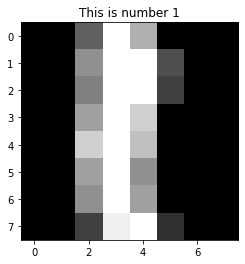

In [13]:
from sklearn.datasets import load_digits

X, y = shuffle(*load_digits(return_X_y=True), random_state=1)

plt.title("This is number %d" % y[0])
plt.imshow(X[0].reshape(8, 8), cmap='gray');

In [14]:
X.max()

16.0

In [15]:
from sklearn.neural_network import MLPClassifier

def preprocess_samples(samples):
    return samples / X.max()

train = int(len(y) * 0.8)

digitizer = MLPClassifier([32, 16], random_state=1).fit(
    preprocess_samples(X[:train]), y[:train]
)

"Accuracy score %.3f" % digitizer.score(
    preprocess_samples(X[train:]), y[train:]
)

'Accuracy score 0.958'

In [16]:
# теперь сохраним всё в файл
import pickle

with open('models/digitizer.pickle', 'wb') as fd:
    # wb - write binary
    pickle.dump({
        'scale': X.max(),
        'model': digitizer
    }, file=fd)

Сервер выглядит вот так (код можно найти в `code/digitzer_service.py`).

```python
from flask import Flask, request, jsonify
app = Flask(__name__)

import pickle
with open('../models/digitizer.pickle', 'rb') as fd:
    methods = pickle.load(fd)
    
scale = methods['scale']
model = methods['model']

import numpy as np
from json import loads

@app.route('/', methods=['POST'])
def index():
    data = loads(request.json)
    result = {
        'prediction': int(
            model.predict(
                np.array([data]).astype(float) / scale
            )[0]
        )
    }
    return jsonify(result)

# файл запустили напрямую
if __name__ == '__main__':
    app.run(host='localhost', port=5555, debug=True)

```

Его необходимо запустить отдельно (например через `python3 digitizer_service.py`), чтобы протестировать.

In [17]:
import json, requests

response = requests.post('http://localhost:5555/', json=json.dumps(X[-1].tolist()))
json.loads(response.content), {'true label': y[-1]}

({'prediction': 5}, {'true label': 5})

## Заключение

Это далеко не всё из того, как можно было бы делать - но вполне себе начало. Благодаря HTTP-запросам, можно обращаться к модели откуда угодно, хоть из браузера (из адресной строки он отправляет `GET`-запрос). Аналогично, микросервис может быть просто `.bat`-файлом - в случае ОС Windows - который запустит python-скрипт, который в свою очередь уже всё сделает. Однако это менее производительный метод, так как каждый раз будет загружаться модель.

## 5.3 Презентация моделей

Мы рассмотрим два метода - `voila` и `streamlit`.

- `voila` - это пакет, позволяющий одной командой запустить `jupyter notebook` (без отображения кода по умолчанию) как интерактивную веб-страницу,
- `streamlit` - это пакет, позволяющий без помощи `jupyter` создавать интерактивные веб-страницы с помощью скриптов прямо на `python`.

Если первый метод прост, то второй метод - это вполне себе замена `jupyter notebooks`, и в последнее время всё более распространяется среди аналитиков данных. По-крайней мере для целей презентации результатов уж точно.

Загляните в директорию `code` - там есть тетрадка под названием `voila_example.ipynb`, её можно запустить с помощью команды `voila code/voila_example.ipynb`. Обратите внимание, что интерактивные виджеты в ней так же будут работать.

Выглядеть это будет примерно так.

![voiled](media/voila_example.png)

А теперь откройте файл `code/streamlit_example.py` - и запустите его командой `streamlit run code/streamlit_example.py`

И выглядеть это будет около того.

![streamlited](media/streamlit_example.png)

## Заключение

Если python - не особо большая проблема - очень рекомендую пользоваться `streamlit` - у него в арсенале не только всевозможные элементы управления (чекбоксы, слайдеры, кнопки и др.), но и всевозможные способы отображения данных: таблицы, множество диаграмм (не только `matplotlib`!), встроена возможность отображать географические карты, и многое-многое другое.

Если надо быстро и просто - можно пользоваться `voila`.

## 5.4 A/B-тестирование

Представьте, что вы создали и развернули модель, но пока не запустили. Когда запустите, будет ли известно, стало лучше или нет? Правильный ответ на этот вопрос - зависит от того, как часто она будет срабатывать по отношению к имеющемуся процессу.

Представим, у нас есть процесс определения сорта ириса на глаз, и с помощью модели. 

> Нельзя сравнивать бизнес-метрики ДО и ПОСЛЕ запуска модели! Можно только С и БЕЗ модели!

Это правило на самом деле из управления реальными инвестиционными проектами. Неправильно задаваться вопросом, лучше ли будет после реализации проекта или нет - правильно задаваться вопросом, будет ли лучше с проектом? Эффект от проекта - это как раз разница между ситуациями "с проектом" и "без проекта".

С моделями аналогично: `эффект от модели = эффект с моделью - эффект без модели.`

Но что, если мы не знаем какой будет эффект с моделью? Мы можем выделить некоторое подмножество примеров в процессе, которые будут обрабатываться моделью, а остальные как прежде. Те, которые будут обрабатываться как прежде - называются **контрольной группой**, а те что по-новому - **тестовой группой**. Поэтому и A/B-тестирование (хотя бывает еще и A/B/C- и A/B/C/D... - A/B/n - и с этим всё немного сложнее, и нужно реже).

Поскольку тестовая и контрольная группа по размерам могут быть (и обычно) разные, мы не можем напрямую сравнивать количество или даже процент ошибок.

In [18]:
control_size = 5000
control_errors = 1000

test_size = 2000
test_errors = 380

print("error rate control %.2f, test %.2f" % (
    control_errors / control_size, test_errors / test_size
))

error rate control 0.20, test 0.19


В таком виде делать заключение - это практически наугад, так как на маленькой выборке (тестовой в данном случае) - было мало данных, и мало ли какие хорошие или плохие они там были (то есть выборка могла быть *нерепрезентативной*).

Сейчас сделаем Байесовский калькулятор, который скажет, какой вариант всё же лучше. Почему Байесовский? Потому что в Байесовском подходе ответ - это распределение величин, а не точечные оценки ("да", или "12.5"). А на распределениях можно будет уже навести некоторую аналитику.

Чтобы её сделать, мы должны найти распределение самой вероятности ошибки, то есть рассмотреть процент ошибок как случайную величину.

К счастью, из теории вероятностей мы можем узнать:
1. есть случайные величины (Бернулли), которые принимают 0 или 1, причем 1 с вероятностью q,
2. для последовательности длиной `n` таких величин с вероятностью "успеха" (в нашем случае ошибки) равной `q` есть распределение под названием *биномиальное*, которое описывает количество "успехов" по отношению к общему числу,
3. в свою очередь, существует распределение (*Beta-распределение*), такое что для серии испытаний длиной `n` с вероятностью "успеха" каждого `q`, верно, что `q` распределена как `Beta`.

Количество ошибок и количество правильных - параметры $\alpha$ и $\beta$. При этом `Beta(1, 1)` эквивалентно равномерному распределению - то есть за один эксперимент равновероятно любое значение. Отметим, что его мат. ожидание $E = \frac {\alpha} {\alpha + \beta}$.

Подытоживая, процент ошибки у нас распределен как `Beta(errors + 1, correct + 1)` - единицу добавляем до всяких экспериментов как *априорное знание*. *Beta-распределение* - это такое распределение, что после применения теоремы Байеса мы получим то же распределение с другими параметрами. Это очень замечательно, ведь нам не придется вычислять напрямую, и будет:

$$P(q) = Beta(\alpha, \beta) => P(q | e, c) = Beta(\alpha + e, \beta + c),$$ где `e` - новые ошибки, `c` - новые корректные примеры.

Проверим непосредственными испытаниями нашу концепцию.

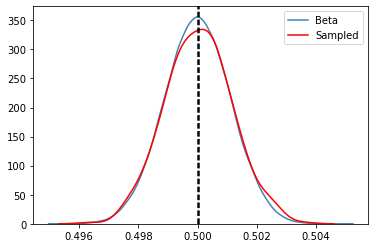

In [19]:
def check_distribution(errors, correct):
    np.random.seed(1)
    
    # случайные вероятности "успеха", пусть 100 миллионов
    percents = np.random.uniform(size=10 ** 8)
    
    # биномиальное распределение, длина серии = ошибки + корректные
    trials = np.random.binomial(n=errors + correct, p=percents)
    
    # посмотрим для сравнения сразу Beta-распределение
    beta_samples = np.random.beta(errors + 1, correct + 1, size=10 ** 5)
    sns.distplot(beta_samples, hist=False, label="Beta", color='steelblue')
    
    # выберем проценты, которые дают то же количество ошибок из общего числа
    samples = percents[
        np.where(trials == errors)
    ]
    
    # и отобразим распределение этих процентов
    sns.distplot(samples, hist=False, label="Sampled", color='red')
    
    plt.axvline(beta_samples.mean(), 0, 1, ls='--', c='black')
    plt.axvline(samples.mean(), 0, 1, ls='--', c='black')
    
    plt.legend(loc='best');
    
# запустим по 100 тысяч успехов и неуспехов
check_distribution(10 ** 5, 10 ** 5)

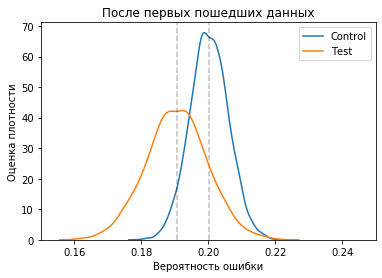

In [20]:
def plot_beta(errors, correct, label, samples=None):
    np.random.seed(1)
    
    X = np.random.beta(errors + 1, correct + 1, size=(errors + correct) if samples is None else samples)
    sns.distplot(X, hist=False, label=label)
    plt.axvline(X.mean(), 0, 1, ls='--', c='black', alpha=0.25)
    
    plt.xlim(0.15, 0.25)
    plt.xlabel('Вероятность ошибки')
    plt.ylabel('Оценка плотности');

plt.title("После первых пошедших данных")
plot_beta(control_errors, control_size - control_errors, 'Control')
plot_beta(test_errors, test_size - test_errors, 'Test')

Вот из этой-то картинки видно, что несмотря на схожесть средних процентов, уверенности в том что вариант с моделью лучше - у нас не так уж и много. Так что же делать? Продолжать, пока не станем уверенными в различиях.

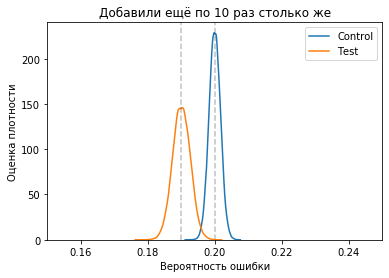

In [21]:
rescale = 10

new_control_errors = control_errors * rescale
new_control_size = control_size * rescale

new_test_errors = test_errors * rescale
new_test_size = test_size * rescale

plt.title("Добавили ещё по %d раз столько же" % rescale)
plot_beta(control_errors + new_control_errors, control_size + new_control_size - control_errors - new_control_errors, 'Control')
plot_beta(test_errors + new_test_errors, test_size + new_test_size - test_errors - new_test_errors, 'Test')

Здесь уже всё выглядит так, что тестовый вариант с моделью определенно лучше. Тем не менее, всё еще остаётся некоторый шанс, что выбрав вариант с моделью, он не будет лучше - так как наши апостериорные распределения пересекаются.

Можно конечно пытаться подсчитать, сколько нужно примеров чтобы распределения разошлись "как в море корабли" (так бывает и делают), а можно выбрать некоторый интервал уверенности, например что пересечение менее 1% незначимо.

## Заключение 

Машинное обучение - как раз для того и нужно, чтобы улучшать процессы. По факту же не всякая модель улучшает. Прояснить, улучшает или нет можно A/B-тестированием. Часто после того, как убедятся в том что вариант с моделью лучше, контрольную выборку делают очень маленькой. Или совсем убирают, когда есть дополнительные метрики для мониторинга эффекта процесса в целом.

# 5.5 Вероятностное программирование

Суть вероятностного программирования - найти не точечные оценки на параметры моделей, а найти их распределение. Делается это, в целом, алгоритмом, похожим на следующее:
1. Взять некоторую начальную позицию (значение каждого параметра),
2. Найти некоторое значение неподалёку от него,
3. Принять или отбросить значение шага 2 в зависимости от того, насколько оно связано с данными и нашими априорными представлениями об их значениях,
4. Если приняли - запомнить, если отбросили - пропустить значение. Перейти на шаг 1.
5. После заданного числа итераций, вернуть все запомненные позиции.

Запомненные позиции в вероятностном программировании называются *samples* (примеры), а их последовательности - *traces* (следы). Как можно отметить, алгоритм не учитывает все предыдущие шаги, а только текущий (то есть "без памяти"). Для сэмпла важно значение, а не путь. И чем случайнее ("перемешаннее") этот путь - тем лучше!

Полученные сэмплы дают некоторое приближение к апостериорному распределению, тому которое нас интересует (оно больше соответствует данным, нежели наше априорное). Что делать с этими сэмплами и следами, давайте посмотрим на примере.

In [22]:
# локальные хаки, могут быть не нужны
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pymc3
pymc3.__version__

'3.9.2'

In [23]:
data = shuffle(pd.read_csv('data/abalone.csv'), random_state=1)

male = data[data.sex == 'M'].drop('sex', axis='columns')
print('Males', len(male))

Males 1528


In [24]:
# возьмемся предсказывать количество колец
target = 'rings'

In [25]:
from sklearn.metrics import mean_absolute_error

def analyze_data(data):
    model = pymc3.Model()
    
    train = data[:2 * len(data) // 3]
    test = data[2 * len(data) // 3:]
    
    with model:
        alpha = pymc3.Normal('alpha', mu=1, sd=1)
        beta =  pymc3.Normal('beta', mu=1, sd=1)
        gamma = pymc3.Normal('gamma', mu=1, sd=1)
        delta = pymc3.Normal('delta', mu=0, sd=0.1)
        
        estimate = alpha * train['diameter'] + beta * train['whole weight'] ** (1 / 3) + gamma * train['shucked weight'] ** (1 / 3) + delta
        observed = pymc3.Poisson('rings', mu=estimate, observed=train[target])
        
        MAP = pymc3.find_MAP()
        traces = pymc3.sample(500, start=MAP, cores=2, chains=2)
    
    y_true = test[target]
    y_pred = traces['alpha'][::2].mean() * test['diameter'] + traces['beta'][::2].mean() * test['whole weight'] ** (1 / 3) + \
             traces['gamma'][::2].mean() * test['shucked weight'] ** (1 / 3) + traces['delta'][::2].mean()
    return model, traces, mean_absolute_error(y_true, y_pred)

male_model, male_traces, male_mae = analyze_data(male)
print("MAE: %.1f" % male_mae)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [delta, gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 108 seconds.


MAE: 2.3


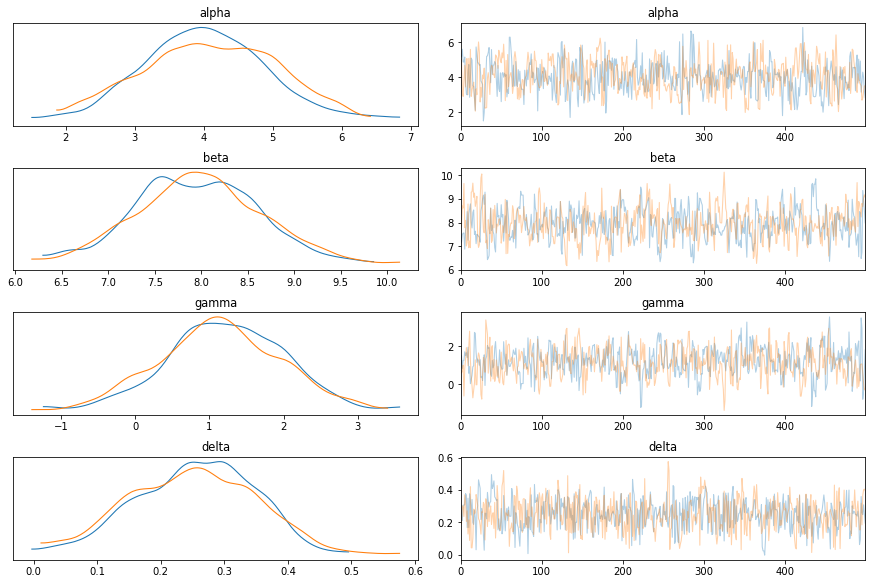

In [26]:
with male_model:
    pymc3.plot_trace(male_traces, var_names=['alpha', 'beta', 'gamma', 'delta']);

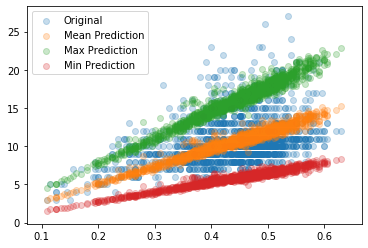

In [27]:
def male_predict(data, operation=np.mean):
    return operation(male_traces['alpha'][::2]) * data['diameter'] + operation(male_traces['beta'][::2]) * data['whole weight'] ** (1 / 3) + \
           operation(male_traces['gamma'][::2]) * data['shucked weight'] ** (1 / 3) + operation(male_traces['delta'][::2])

plt.scatter(male.diameter, male[target], alpha=0.25, label='Original');
plt.scatter(male.diameter, male_predict(male), alpha=0.25, label='Mean Prediction');
plt.scatter(male.diameter, male_predict(male, operation=np.max), alpha=0.25, label='Max Prediction');
plt.scatter(male.diameter, male_predict(male, operation=np.min), alpha=0.25, label='Min Prediction');
plt.legend(loc='best');

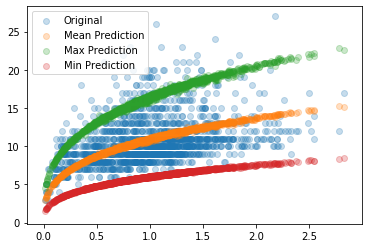

In [28]:
plt.scatter(male['whole weight'], male[target], alpha=0.25, label='Original');
plt.scatter(male['whole weight'], male_predict(male), alpha=0.25, label='Mean Prediction');
plt.scatter(male['whole weight'], male_predict(male, operation=np.max), alpha=0.25, label='Max Prediction');
plt.scatter(male['whole weight'], male_predict(male, operation=np.min), alpha=0.25, label='Min Prediction');
plt.legend(loc='best');

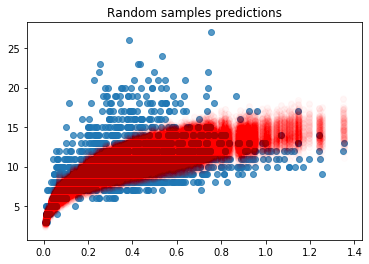

In [29]:
plt.title('Random samples predictions')
plt.scatter(male['shucked weight'], male[target], alpha=0.75, label='Original')
for _ in range(100):
    plt.scatter(male['shucked weight'], male_predict(male, operation=np.random.choice), c='red', alpha=0.01);